In [12]:
#Librairies

from __future__ import division, print_function, unicode_literals
import os
import tarfile
from six.moves import urllib
import pandas as pd
import numpy as np
import os
from six.moves import urllib
from scipy.io import loadmat
import matplotlib
import matplotlib.pyplot as plt
import statistics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_curve
pd.set_option('display.max_columns', None)
from os import listdir
from os.path import isfile, join
from PIL import Image
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
#np.set_printoptions(threshold=np.inf)
np.set_printoptions(threshold=None)

np.random.seed(42)
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

<h1> I - Importation des données

<h3>A) Récuperation des labels

In [13]:
label_data_columns = ["t_video","timestamp","general_posture_Annotator1","general_posture_Annotator2","general_posture_Annotator3","detailed_posture_Annotator1","detailed_posture_Annotator2","detailed_posture_Annotator3","current_action_Annotator1","current_action_Annotator2","current_action_Annotator3"]


def load_housing_data(housing_path,columns=[]):
    if(len(columns)>0):
        data = pd.read_csv(housing_path,delimiter=",",names = columns,header=1)
    else:
        data = pd.read_csv(housing_path,delimiter=",")
    return data
lst_participant = ["541"]

data_brute = []
for participant in lst_participant:
    fichiers = [f for f in listdir("labels_csv/Participant_"+participant) if isfile(join("labels_csv/Participant_"+participant, f))]
    for fichier in fichiers:
        data_brute.append(load_housing_data("labels_csv/Participant_"+participant+"/"+fichier,label_data_columns))

<h3>A) Récuperation des images (train)

In [14]:
from datetime import timedelta
import cv2
import numpy as np
import os
SAVING_FRAMES_PER_SECOND = 25

def format_timedelta(td):
    result = str(td)
    try:
        result, ms = result.split(".")
    except ValueError:
        return result + ".00".replace(":", "-")
    ms = int(ms)
    ms = round(ms / 1e4)
    return f"{result}.{ms:02}".replace(":", "-")


def get_saving_frames_durations(cap, saving_fps):
    """A function that returns the list of durations where to save the frames"""
    s = []
    # get the clip duration by dividing number of frames by the number of frames per second
    clip_duration = cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS)
    # use np.arange() to make floating-point steps
    for i in np.arange(0, clip_duration, 1 / saving_fps):
        s.append(i)
    return s

def main(video_file):
    filename, _ = os.path.splitext(video_file)
    filename += "-opencv"
    # make a folder by the name of the video file
    if not os.path.isdir(filename):
        os.mkdir(filename)
    # read the video file    
    cap = cv2.VideoCapture(video_file)
    # get the FPS of the video
    fps = cap.get(cv2.CAP_PROP_FPS)
    # if the SAVING_FRAMES_PER_SECOND is above video FPS, then set it to FPS (as maximum)
    saving_frames_per_second = min(fps, SAVING_FRAMES_PER_SECOND)
    # get the list of duration spots to save
    saving_frames_durations = get_saving_frames_durations(cap, saving_frames_per_second)
    # start the loop
    count = 0
    while True:
        is_read, frame = cap.read()
        if not is_read:
            # break out of the loop if there are no frames to read
            break
        # get the duration by dividing the frame count by the FPS
        frame_duration = count / fps
        try:
            # get the earliest duration to save
            closest_duration = saving_frames_durations[0]
        except IndexError:
            # the list is empty, all duration frames were saved
            break
        if frame_duration >= closest_duration:
            # if closest duration is less than or equals the frame duration, 
            # then save the frame
            frame_duration_formatted = format_timedelta(timedelta(seconds=frame_duration))
            cv2.imwrite(os.path.join(filename, f"frame{frame_duration_formatted}.jpg"), frame) 
            # drop the duration spot from the list, since this duration spot is already saved
            try:
                saving_frames_durations.pop(0)
            except IndexError:
                pass
        # increment the frame count
        count += 1

<h1> II - Préparation des données

<h3>A) Transformation des videos en frames

In [5]:
for participant in lst_participant:
    fichiers = [f for f in listdir("Video/Participant_"+participant) if isfile(join("Video/Participant_"+participant, f))]
    for fichier in fichiers:
        main("Video/Participant_"+participant+"/"+fichier)

KeyboardInterrupt: 

In [15]:
def plot_digit(data):
    plt.imshow(data, cmap = matplotlib.cm.binary,
           interpolation="nearest")
    plt.show()

<h3>B) Récuperation des Frames

In [16]:
def get_all_image(file_path):
    fichiers = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    ret=[]
    i=0
    for frame in fichiers:
        image = Image.open(file_path+"/"+frame)
        im = np.array(image)
        ret.append(im)
        i+=1
    print(i)
    return ret



In [17]:
all_frames = []
for participant in lst_participant:
    rootdir = "Video/Participant_"+participant
    for file in os.listdir(rootdir):
        dossier = os.path.join(rootdir, file)
        dossier = dossier.replace("\\",'/')
        if os.path.isdir(dossier):
            print(dossier)
            all_frames.append(get_all_image(dossier))
    


Video/Participant_541/Participant_541_Setup_A_Seq_3_Trial_1.camera1-converted-opencv
2370
Video/Participant_541/Participant_541_Setup_A_Seq_3_Trial_2.camera1-converted-opencv
2478
Video/Participant_541/Participant_541_Setup_A_Seq_3_Trial_3.camera1-converted-opencv
2754
Video/Participant_541/Participant_541_Setup_A_Seq_3_Trial_4.camera1-converted-opencv
2814
Video/Participant_541/Participant_541_Setup_A_Seq_3_Trial_5.camera1-converted-opencv
2754
Video/Participant_541/Participant_541_Setup_A_Seq_4_Trial_1.camera1-converted-opencv
3834
Video/Participant_541/Participant_541_Setup_A_Seq_4_Trial_2.camera1-converted-opencv
2478
Video/Participant_541/Participant_541_Setup_A_Seq_4_Trial_3.camera1-converted-opencv
2610
Video/Participant_541/Participant_541_Setup_A_Seq_4_Trial_4.camera1-converted-opencv
2706
Video/Participant_541/Participant_541_Setup_A_Seq_4_Trial_5.camera1-converted-opencv
2418
Video/Participant_541/Participant_541_Setup_A_Seq_5_Trial_1.camera1-converted-opencv
2826
Video/Part

In [18]:
print(len(all_frames))

15


<h3>C) Normalisation du nombre de test du fichier excel au nombre de frame (train)

In [19]:
for index_video in range(0,len(all_frames)):
    data_brute[index_video].drop(data_brute[index_video].index[len(all_frames[index_video]):], inplace=True)

<h3>D) Création du Label

In [20]:
def create_label(df,frames):
    df["label"] =  ["vide" for i in range(df.shape[0])]
    for i in df.index: 
        if df["detailed_posture_Annotator1"][i] != df["detailed_posture_Annotator2"][i] and df["detailed_posture_Annotator2"][i]==df["detailed_posture_Annotator3"][i]:
            df["detailed_posture_Annotator1"][i] = df["detailed_posture_Annotator2"][i]

        if df["current_action_Annotator1"][i] != df["current_action_Annotator2"][i] and df["current_action_Annotator2"][i]==df['current_action_Annotator3'][i]:
            df["current_action_Annotator1"][i] = df["current_action_Annotator2"][i]
        df["label"] = df["detailed_posture_Annotator1"]+"_"+df["current_action_Annotator1"]
    data = pd.DataFrame(df.label)
    data["frames"] = frames
    return data

In [21]:
for i in range(len(data_brute)):
    data_brute[i] = create_label(data_brute[i],all_frames[i])

C:\Users\ludov\AppData\Local\Temp\ipykernel_5504\2646605259.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["current_action_Annotator1"][i] = df["current_action_Annotator2"][i]
C:\Users\ludov\AppData\Local\Temp\ipykernel_5504\2646605259.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["detailed_posture_Annotator1"][i] = df["detailed_posture_Annotator2"][i]
C:\Users\ludov\AppData\Local\Temp\ipykernel_5504\2646605259.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

C:\Users\ludov\AppData\Local\Temp\ipykernel_5504\2646605259.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["detailed_posture_Annotator1"][i] = df["detailed_posture_Annotator2"][i]
C:\Users\ludov\AppData\Local\Temp\ipykernel_5504\2646605259.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["current_action_Annotator1"][i] = df["current_action_Annotator2"][i]
C:\Users\ludov\AppData\Local\Temp\ipykernel_5504\2646605259.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

<h3>E) Concatenation des différents dataframes en 1

In [22]:
data = pd.concat(data_brute,axis=0)
data = data.reset_index(drop=True)
data = data[data.groupby('label')['label'].transform('size') > 1]
data = data.reset_index(drop=True)

<h3>F) Reduction des données :

In [23]:
img = data["frames"][0]

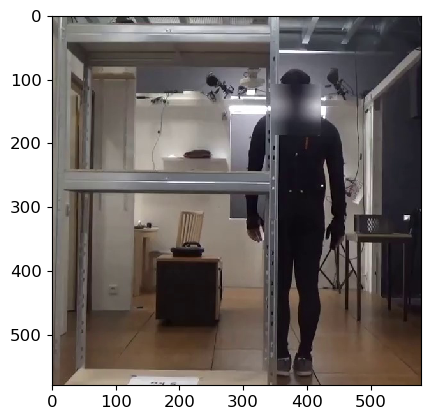

In [24]:
plot_digit(img)

In [25]:
def convert_to_grayscale(image):
    image = Image.fromarray(image)
    # Conversion en niveaux de gris
    grayscale_image = image.convert("L")
    
    # Conversion en un tableau NumPy
    numpy_array = np.array(grayscale_image)
    
    return numpy_array

img2 = convert_to_grayscale(img)

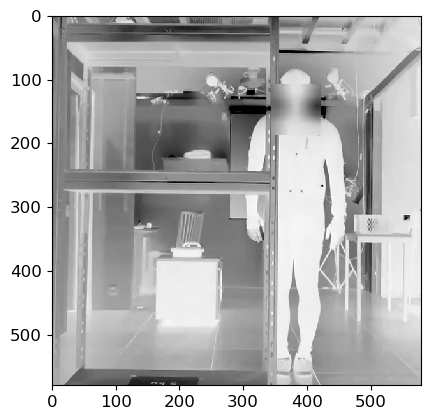

In [26]:
plot_digit(img2)

In [27]:
for i in range(int(len(data["frames"])/4)): 
    data['frames'][i] = convert_to_grayscale(data['frames'][i])

In [28]:
for i in range(int(len(data["frames"])/4),int(2*len(data["frames"])/4)):
    data['frames'][i] = convert_to_grayscale(data['frames'][i])

In [29]:
for i in range(int(2*len(data["frames"])/4),int(3*len(data["frames"])/4)):
    data['frames'][i] = convert_to_grayscale(data['frames'][i])

In [30]:
for i in range(int(3*len(data["frames"])/4),int(len(data["frames"]))):
    data['frames'][i] = convert_to_grayscale(data['frames'][i])

In [31]:
data['frames'][int(len(data["frames"])/4-1)]

array([[129, 134, 137, ...,  30,  31,  31],
       [123, 129, 132, ...,  31,  32,  30],
       [113, 123, 130, ...,  31,  32,  30],
       ...,
       [ 80,  80,  80, ...,  78,  79,  79],
       [ 80,  80,  80, ...,  78,  79,  79],
       [ 80,  80,  80, ...,  78,  79,  79]], dtype=uint8)

<h1> III - Division du jeu de données en train test

In [32]:
split = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42)


for train_index, test_index in split.split(data,data["label"]):
    train_set = data.loc[train_index]
    test_set = data.loc[test_index]

In [33]:
train_set.head()

,label,frames
20393,St_BS_Fm,"[[138, 142, 138, 133, 130, 132, 136, 134, 124,..."
20040,Cr_BF_Fm,"[[138, 142, 143, 139, 135, 132, 131, 133, 121,..."
18390,St_U_Sc,"[[130, 131, 135, 134, 132, 131, 130, 132, 119,..."
7667,St_U_Id,"[[138, 138, 140, 142, 142, 140, 137, 134, 132,..."
26972,St_U_Id,"[[127, 136, 135, 134, 136, 136, 138, 139, 129,..."


In [34]:
Y_train = train_set["label"]
X_train = train_set["frames"]
X_train[0:20000] = X_train[0:20000].apply(lambda x: x.flatten())

In [35]:
X_train[20000:] = X_train[20000:].apply(lambda x: x.flatten())

In [36]:
X_train1 = X_train.reset_index(drop=True)
Y_train1 = Y_train.reset_index(drop=True)

In [37]:
X_train1

0        [138, 142, 138, 133, 130, 132, 136, 134, 124, ...
1        [138, 142, 143, 139, 135, 132, 131, 133, 121, ...
2        [130, 131, 135, 134, 132, 131, 130, 132, 119, ...
3        [138, 138, 140, 142, 142, 140, 137, 134, 132, ...
4        [127, 136, 135, 134, 136, 136, 138, 139, 129, ...
                               ...                        
32312    [101, 104, 107, 107, 107, 109, 111, 113, 121, ...
32313    [105, 106, 109, 112, 113, 112, 113, 115, 128, ...
32314    [128, 132, 135, 135, 134, 135, 135, 136, 131, ...
32315    [101, 103, 104, 105, 106, 108, 109, 109, 118, ...
32316    [138, 137, 135, 136, 138, 136, 136, 132, 125, ...
Name: frames, Length: 32317, dtype: object

In [38]:
X_train2 = np.array(X_train1)
Y_train2 = np.array(Y_train1)

In [39]:
X_train2

array([array([138, 142, 138, ...,  75,  75,  75], dtype=uint8),
       array([138, 142, 143, ...,  74,  74,  74], dtype=uint8),
       array([130, 131, 135, ...,  74,  73,  73], dtype=uint8), ...,
       array([128, 132, 135, ...,  78,  77,  77], dtype=uint8),
       array([101, 103, 104, ...,  74,  74,  74], dtype=uint8),
       array([138, 137, 135, ...,  75,  75,  75], dtype=uint8)],
      dtype=object)

In [40]:
X_train3 = np.vstack(X_train2)
X_train3

array([[138, 142, 138, ...,  75,  75,  75],
       [138, 142, 143, ...,  74,  74,  74],
       [130, 131, 135, ...,  74,  73,  73],
       ...,
       [128, 132, 135, ...,  78,  77,  77],
       [101, 103, 104, ...,  74,  74,  74],
       [138, 137, 135, ...,  75,  75,  75]], dtype=uint8)

In [42]:
Y_train2

array(['St_BS_Fm', 'Cr_BF_Fm', 'St_U_Sc', ..., 'St_U_Id', 'St_U_Id',
       'St_U_Id'], dtype=object)

<h3>Reduction du jeu de donnée train

In [43]:
X_train = X_train3[:3000]
Y_train = Y_train2[:3000]

In [44]:
X_train

array([[138, 142, 138, ...,  75,  75,  75],
       [138, 142, 143, ...,  74,  74,  74],
       [130, 131, 135, ...,  74,  73,  73],
       ...,
       [127, 136, 137, ...,  77,  77,  77],
       [132, 143, 143, ...,  76,  75,  75],
       [132, 137, 136, ...,  74,  74,  74]], dtype=uint8)

In [45]:
Y_train

array(['St_BS_Fm', 'Cr_BF_Fm', 'St_U_Sc', ..., 'St_U_Id', 'St_U_Fm',
       'St_U_Sc'], dtype=object)

<h1> IV - Entrainement des models

<h3>A) Neural network model

In [34]:
clf_BP_ANN = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=42)

In [49]:
clf_BP_ANN.fit(X_train,Y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=42,
              solver='lbfgs')

<h3>B) Decision tree

In [35]:
clf_DT = DecisionTreeClassifier(random_state=42)

In [ ]:
clf_DT.fit(X_train,Y_train)

<h3>C) Support vector model

In [36]:
clf_SVM = LinearSVC(random_state=42)

In [ ]:
clf_SVM.fit(X_train,Y_train)

<h3>D) K-nearest neighbors

In [37]:
clf_KNN = KNeighborsClassifier()

In [ ]:
clf_KNN.fit(X_train,Y_train)

<h1>V) Comparaison des performances des models

In [40]:
accuracy_BP_ANN = cross_val_score(clf_BP_ANN, X_train, Y_train, cv=5, scoring="accuracy")

C:\Users\ludov\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [58]:
print(accuracy_BP_ANN)

[0.21333333 0.21333333 0.215      0.21333333 0.21333333]


In [42]:
accuracy_DT = cross_val_score(clf_DT, X_train, Y_train, cv=5, scoring="accuracy")

C:\Users\ludov\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [43]:
print(accuracy_DT)

[0.4  0.3  0.25 0.25 0.2 ]


In [ ]:
accuracy_SVM = cross_val_score(clf_SVM, X_train, Y_train, cv=5, scoring="accuracy")

C:\Users\ludov\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ludov\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
print(accuracy_SVM)

In [38]:
accuracy_KNN = cross_val_score(clf_KNN, X_train, Y_train, cv=5, scoring="accuracy")

C:\Users\ludov\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ludov\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\ludov\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this beh

In [39]:
print(accuracy_KNN)

[0.445 0.5   0.475 0.42  0.425]


<h3>Tableau de comparaison des models :

In [10]:
comparaison = pd.DataFrame([["BP ANN",statistics.mean(accuracy_BP_ANN)],["Decision tree",statistics.mean(accuracy_DT)],["SVM",statistics.mean(accuracy_SVM)],["KNN",statistics.mean(accuracy_KNN)]],columns=["Models","Accuracy"])

comparaison.head()

,Models,Accuracy
0,BP ANN,0.213667
1,Decision tree,0.280000
2,SVM,0.202000
3,KNN,0.453000
